In [1]:
import os
import sys
import re
from pathlib import Path
from itertools import combinations

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
from larval_gonad.notebook import Nb

In [2]:
# Setup notebook
nbconfig = Nb.setup_notebook(seurat_dir='../output/scrnaseq-wf/scrnaseq_combine_force')

last updated: 2019-03-08 
Git hash: 42ad8aad8aa838a82446e4d63cd2facbb4bcaa5a


In [75]:
clusters = (
    pd.read_parquet('../output/paper_submission/clusters.parquet')
    .query('cluster != "UNK"')
    .assign(
        cluster=lambda df: (
            df.cluster.astype('category')
            .cat.as_ordered()
            .cat.reorder_categories(nbconfig.short_cluster_order)
        )
    )
)

In [76]:
df = (
    pd.read_parquet('../output/scrnaseq-wf/raw.parquet')
    .sum()
    .rename('total_UMI')
    .rename_axis('cell_id')
    .to_frame()
    .assign(rep = lambda df: df.index.str.extract('(rep\d)', expand=False))
    .assign(log_total_UMI=lambda df: np.log10(df.total_UMI))
    .join(clusters)
)

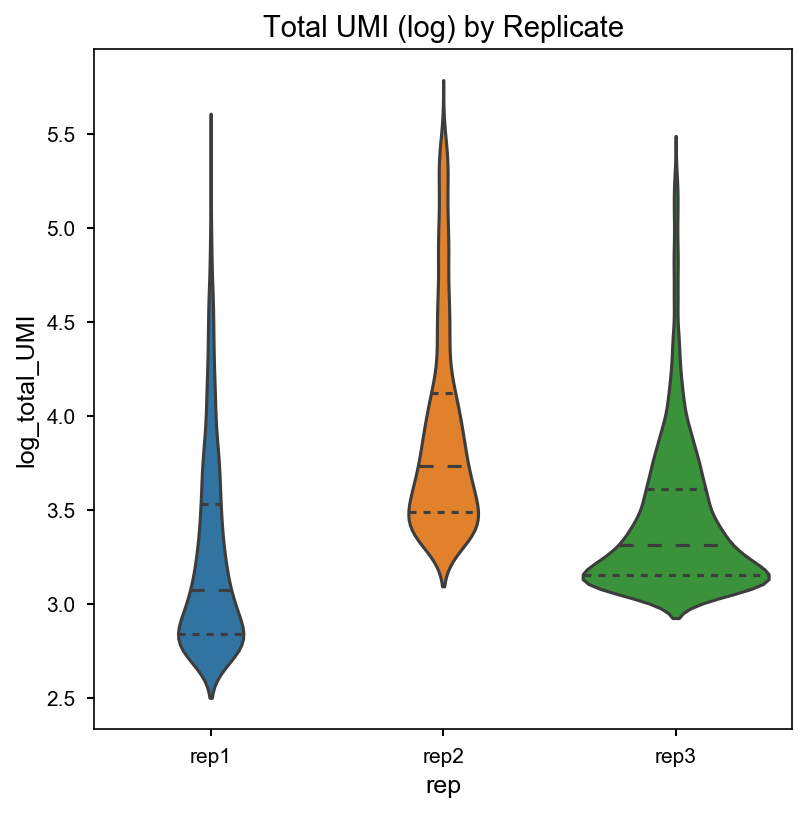

In [85]:
sns.violinplot('rep', 'log_total_UMI', data=df, scale='count', inner='quartile')
plt.title('Total UMI (log) by Replicate');

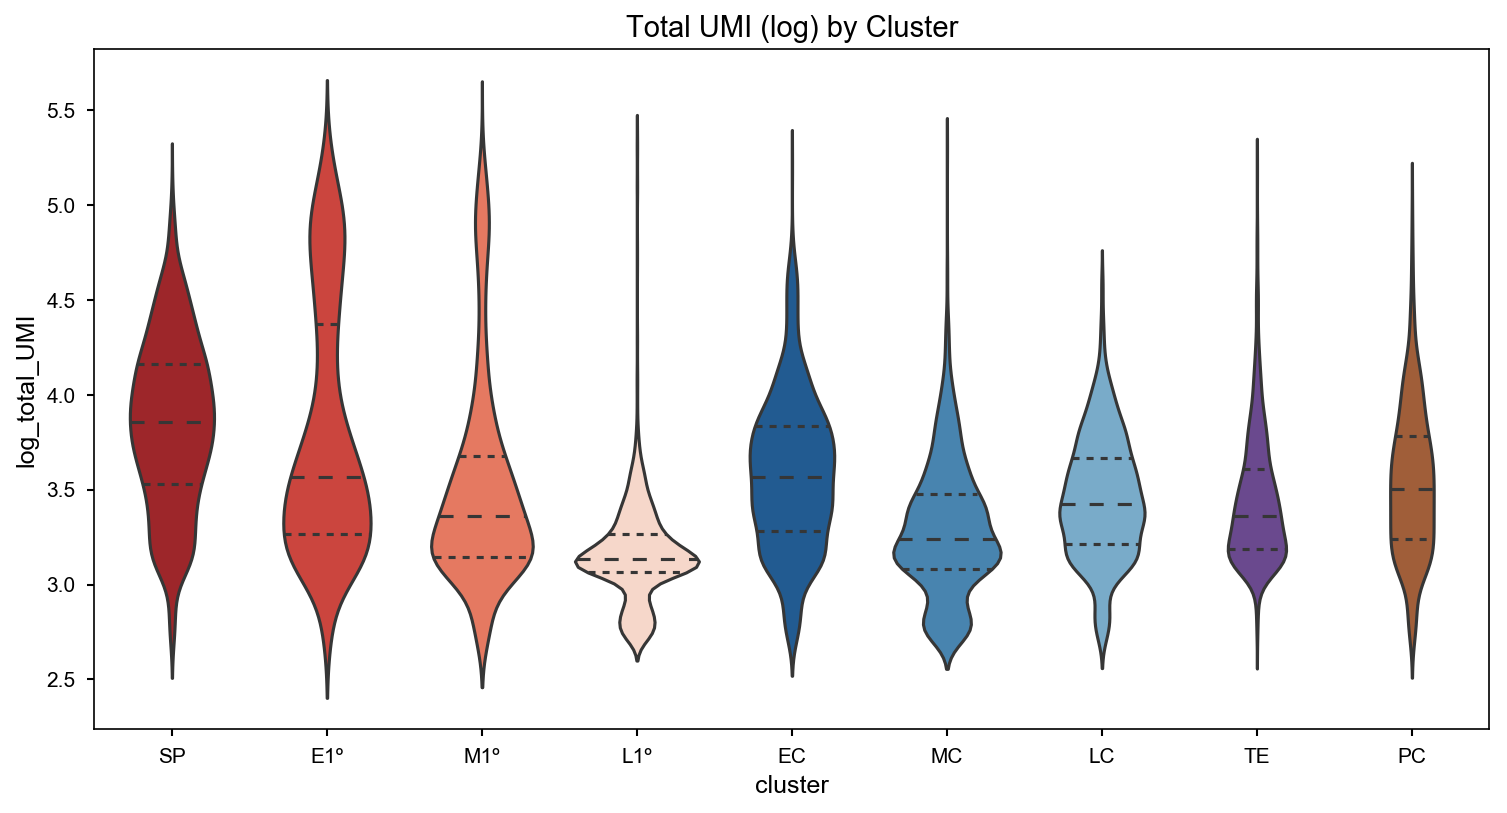

In [87]:
fig = plt.figure(figsize=(plt.figaspect(1/2)))
sns.violinplot('cluster', 'log_total_UMI', data=df, scale='count', inner='quartile', palette=nbconfig.colors['clusters'])
plt.title('Total UMI (log) by Cluster');

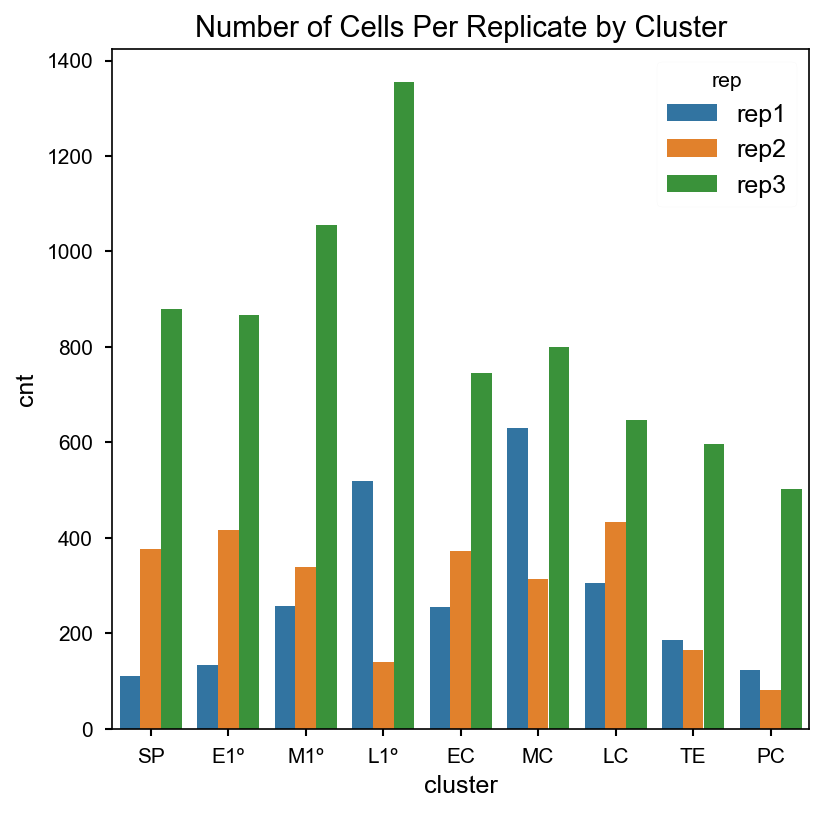

In [90]:
sns.barplot('cluster', 'cnt', data=df.groupby(['rep', 'cluster']).size().rename('cnt').to_frame().reset_index(), hue='rep')
plt.title('Number of Cells Per Replicate by Cluster');

In [91]:
for c1, c2 in combinations(nbconfig.short_cluster_order, 2):
    _, pval = mannwhitneyu(
        df.query(f'cluster == "{c1}"').total_UMI.values,
        df.query(f'cluster == "{c2}"').total_UMI.values,
        alternative='two-sided'
    )
    print(f'{c1:<5} {c2:<5} {pval < 0.001}')

SP    E1º   True
SP    M1º   True
SP    L1º   True
SP    EC    True
SP    MC    True
SP    LC    True
SP    TE    True
SP    PC    True
E1º   M1º   True
E1º   L1º   True
E1º   EC    True
E1º   MC    True
E1º   LC    True
E1º   TE    True
E1º   PC    True
M1º   L1º   True
M1º   EC    True
M1º   MC    True
M1º   LC    False
M1º   TE    False
M1º   PC    True
L1º   EC    True
L1º   MC    True
L1º   LC    True
L1º   TE    True
L1º   PC    True
EC    MC    True
EC    LC    True
EC    TE    True
EC    PC    False
MC    LC    True
MC    TE    True
MC    PC    True
LC    TE    False
LC    PC    True
TE    PC    True


In [92]:
df.groupby('cluster').total_UMI.median().map(lambda x: f'{x:,.2f}')

cluster
SP     7,206.00
E1º    3,699.00
M1º    2,307.00
L1º    1,363.00
EC     3,701.00
MC     1,746.50
LC     2,671.50
TE     2,306.00
PC     3,206.00
Name: total_UMI, dtype: object

In [93]:
df = (
    pd.read_parquet('../output/scrnaseq-wf/raw.parquet')
    .pipe(lambda df: df > 0)
    .sum()
    .rename('expressed_genes')
    .rename_axis('cell_id')
    .to_frame()
    .assign(log_expressed_genes=lambda df: np.log10(df.expressed_genes + 1))
    .join(clusters, how='inner')
)

Text(0.5,1,'Expressed Genes by Cluster')

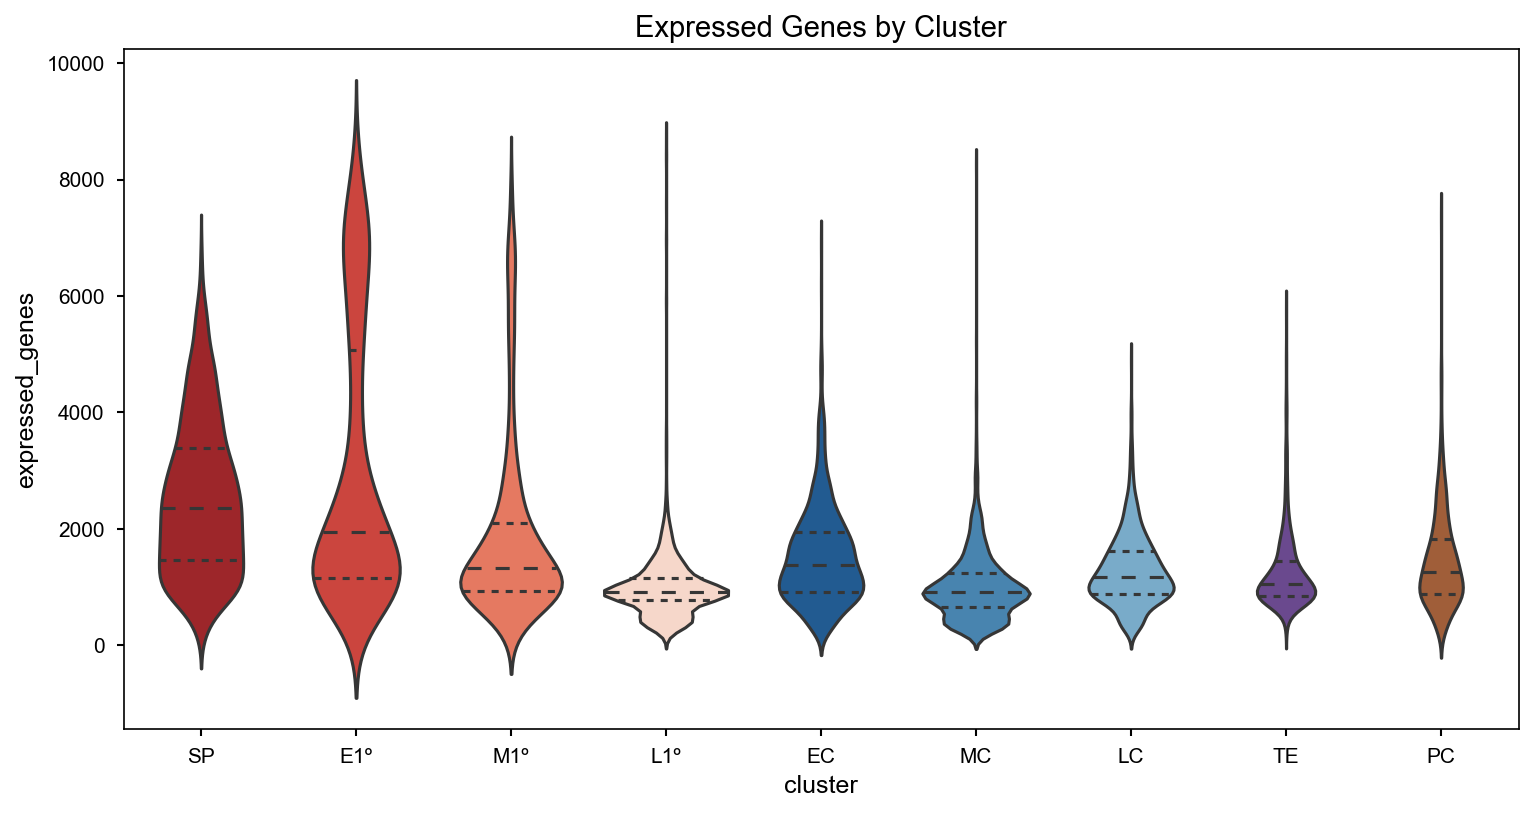

In [94]:
fig = plt.figure(figsize=plt.figaspect(1/2))
sns.violinplot('cluster', 'expressed_genes', data=df, palette=nbconfig.colors['clusters'], scale='count', inner='quartile')
plt.title('Expressed Genes by Cluster')

In [95]:
for c1, c2 in combinations(nbconfig.short_cluster_order, 2):
    _, pval = mannwhitneyu(
        df.query(f'cluster == "{c1}"').expressed_genes.values,
        df.query(f'cluster == "{c2}"').expressed_genes.values,
        alternative='two-sided'
    )
    print(f'{c1:<5} {c2:<5} {pval < 0.001}')

SP    E1º   False
SP    M1º   True
SP    L1º   True
SP    EC    True
SP    MC    True
SP    LC    True
SP    TE    True
SP    PC    True
E1º   M1º   True
E1º   L1º   True
E1º   EC    True
E1º   MC    True
E1º   LC    True
E1º   TE    True
E1º   PC    True
M1º   L1º   True
M1º   EC    False
M1º   MC    True
M1º   LC    True
M1º   TE    True
M1º   PC    True
L1º   EC    True
L1º   MC    False
L1º   LC    True
L1º   TE    True
L1º   PC    True
EC    MC    True
EC    LC    True
EC    TE    True
EC    PC    False
MC    LC    True
MC    TE    True
MC    PC    True
LC    TE    True
LC    PC    False
TE    PC    True


In [97]:
df.groupby('cluster').expressed_genes.mean().map(lambda x: f'{x:,.2f}')

cluster
SP     2,528.81
E1º    3,000.12
M1º    1,921.60
L1º      997.45
EC     1,541.38
MC     1,010.70
LC     1,293.45
TE     1,259.32
PC     1,442.12
Name: expressed_genes, dtype: object

In [114]:
biomarkers = (
    pd.read_csv('../output/scrnaseq-wf/scrnaseq_combine_force/biomarkers_res.0.6.tsv', sep='\t', index_col=0, usecols=['primary_FBgn', 'cluster'])
    .cluster
    .rename_axis('FBgn')
    .map(nbconfig.short_cluster_annot)
    .pipe(lambda x: x[x != 'UNK'])
    .astype('category')
    .cat.as_ordered()
    .cat.reorder_categories(nbconfig.short_cluster_order)
    .to_frame()
)

In [120]:
unique = biomarkers.groupby('FBgn').size().pipe(lambda x: x[x == 1]).index

In [128]:
l1 = biomarkers[biomarkers.index.isin(unique)].query('cluster == "L1º"').index

In [132]:
for g in l1:
    print(f'{g:<12} {nbconfig.fbgn2symbol[g]}')

FBgn0013672  mt:ATPase6
FBgn0013678  mt:Cyt-b
FBgn0013685  mt:ND6
FBgn0032193  CG5727
FBgn0032372  CG4988
FBgn0036070  CG8072
FBgn0038421  CG17931
FBgn0085229  CG34200
FBgn0261522  CR42657
FBgn0267412  CG45765


In [133]:
l1.tolist()

['FBgn0013672',
 'FBgn0013678',
 'FBgn0013685',
 'FBgn0032193',
 'FBgn0032372',
 'FBgn0036070',
 'FBgn0038421',
 'FBgn0085229',
 'FBgn0261522',
 'FBgn0267412']

In [338]:
df = (
    pd.read_parquet('../output/scrnaseq-wf/raw.parquet').T
    .join(clusters)
    .groupby('cluster')
    .sum()
    .T
)
df

cluster,SP,E1º,M1º,L1º,EC,MC,LC,TE,PC
FBgn0031081,4,19,4,2,9,10,33,1,0
FBgn0031085,890,14214,12232,2343,443,724,506,254,311
FBgn0040784,4736,10270,2907,929,249,320,197,116,123
FBgn0031086,11,11,1,0,2,0,0,0,0
FBgn0031082,222,2508,2051,406,108,157,109,64,63
FBgn0031080,7,5,4,0,28,50,76,2,1
FBgn0053217,793,1234,251,99,255,113,138,139,107
FBgn0052350,207,91,19,6,94,18,38,97,68
FBgn0024733,77338,32800,6260,2898,37741,12027,15035,16793,20017
FBgn0040372,1422,852,239,78,318,70,137,535,244


In [221]:
binned = df.apply(partial(pd.qcut, q=4, labels=['lowest', 'low', 'high', 'highest'], duplicates='drop'), axis=0)

In [222]:
binned[binned.index.isin(l1)]

cluster,SP,E1º,M1º,L1º,EC,MC,LC,TE,PC
FBgn0032193,highest,highest,highest,highest,highest,highest,highest,highest,high
FBgn0032372,high,high,highest,highest,high,high,high,high,high
FBgn0038421,highest,highest,highest,highest,high,highest,high,highest,highest
FBgn0013672,highest,highest,highest,highest,highest,highest,highest,highest,highest
FBgn0013685,high,high,high,highest,highest,highest,highest,highest,highest
FBgn0013678,highest,highest,highest,highest,highest,highest,highest,highest,highest
FBgn0085229,highest,highest,highest,highest,highest,highest,highest,highest,highest
FBgn0261522,high,highest,highest,highest,high,high,high,high,high
FBgn0267412,low,high,highest,highest,low,high,high,low,low
FBgn0036070,highest,highest,highest,highest,low,high,high,low,high


In [227]:
binned[['M1º', 'L1º']]

cluster,M1º,L1º
FBgn0031081,lowest,lowest
FBgn0031085,highest,highest
FBgn0040784,highest,highest
FBgn0031086,lowest,lowest
FBgn0031082,highest,highest
FBgn0031080,lowest,lowest
FBgn0053217,high,high
FBgn0052350,low,low
FBgn0024733,highest,highest
FBgn0040372,high,high


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

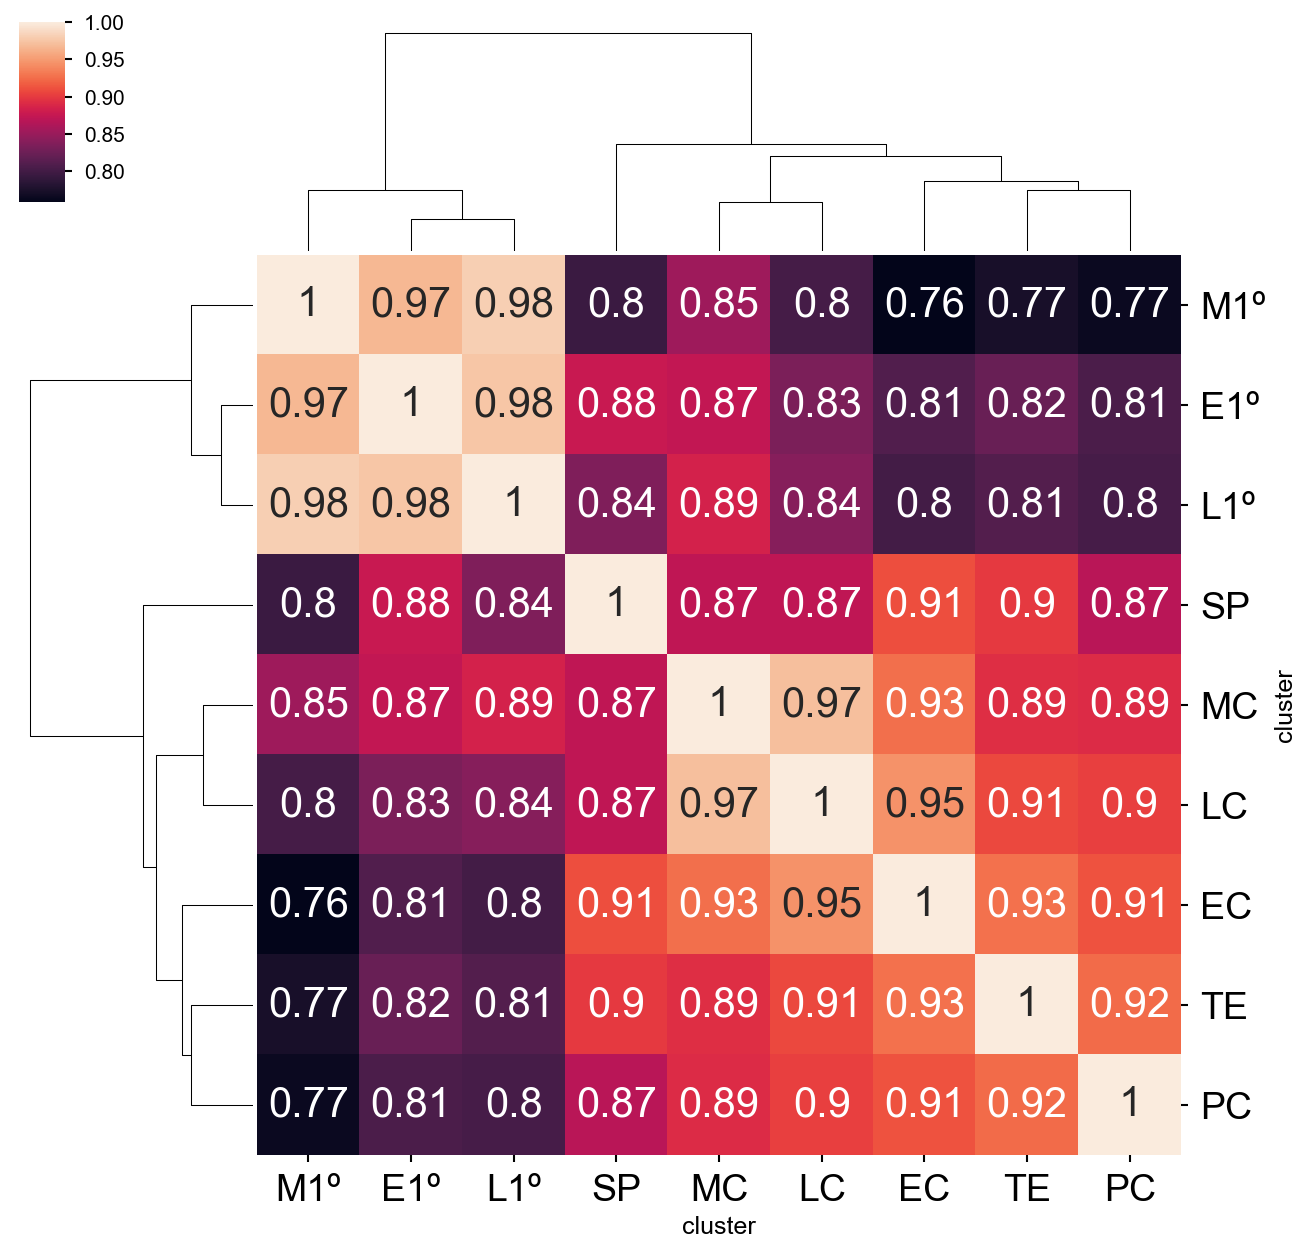

In [341]:
g = sns.clustermap(df.corr(method='spearman'), annot=True)
plt.setp(g.ax_heatmap.get_xticklabels(), fontsize=18)
plt.setp(g.ax_heatmap.get_yticklabels(), fontsize=18, rotation=0)

In [242]:
bd = binned[~((binned == 'lowest').all(axis=1) |  (binned == 'low').all(axis=1) | (binned == 'high').all(axis=1) |  (binned == 'highest').all(axis=1))]

In [243]:
bd

cluster,SP,E1º,M1º,L1º,EC,MC,LC,TE,PC
FBgn0031081,lowest,lowest,lowest,lowest,low,low,low,lowest,lowest
FBgn0040784,highest,highest,highest,highest,highest,highest,highest,high,highest
FBgn0031086,low,lowest,lowest,lowest,lowest,lowest,lowest,lowest,lowest
FBgn0031082,high,highest,highest,highest,high,high,high,high,high
FBgn0031080,low,lowest,lowest,lowest,low,high,high,low,lowest
FBgn0053217,highest,high,high,high,highest,high,high,highest,high
FBgn0052350,high,low,low,low,high,low,high,high,high
FBgn0040372,highest,high,high,high,highest,high,high,highest,highest
FBgn0000316,high,low,low,low,high,low,low,high,high
FBgn0004034,lowest,lowest,lowest,lowest,lowest,low,low,lowest,lowest


In [254]:
df.apply(partial(pd.cut, bins=2, labels=['low', 'high'], duplicates='drop'), axis=1)

cluster,SP,E1º,M1º,L1º,EC,MC,LC,TE,PC
FBgn0031081,low,high,low,low,low,low,high,low,low
FBgn0031085,low,high,high,low,low,low,low,low,low
FBgn0040784,low,high,low,low,low,low,low,low,low
FBgn0031086,high,high,low,low,low,low,low,low,low
FBgn0031082,low,high,high,low,low,low,low,low,low
FBgn0031080,low,low,low,low,low,high,high,low,low
FBgn0053217,high,high,low,low,low,low,low,low,low
FBgn0052350,high,low,low,low,low,low,low,low,low
FBgn0024733,high,low,low,low,low,low,low,low,low
FBgn0040372,high,high,low,low,low,low,low,low,low


In [252]:
df.loc['FBgn0031086', :]

cluster
SP     11
E1º    11
M1º     1
L1º     0
EC      2
MC      0
LC      0
TE      0
PC      0
Name: FBgn0031086, dtype: int64

In [270]:
X = (
    pd.read_parquet('../output/scrnaseq-wf/raw.parquet').T
    .join(clusters)
    .query('cluster == ["M1º", "L1º"]')
    .drop('cluster', axis=1)
)

Y = (
    pd.read_parquet('../output/scrnaseq-wf/raw.parquet').T
    .join(clusters)
    .query('cluster == ["M1º", "L1º"]')
    .cluster
    .values
    .tolist()
)

In [271]:
cell_ids = X.index
genes = X.columns
X = X.values

In [272]:
X

array([[0, 2, 3, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 2, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [273]:
from sklearn.ensemble import RandomForestClassifier

In [274]:
RF = RandomForestClassifier(n_jobs=10)

In [275]:
RF.fit(X, Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=10,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [293]:
cand = pd.Series(RF.feature_importances_, index=genes).sort_values(ascending=False).head(50).index
list(map(lambda x: (x, nbconfig.fbgn2symbol[x]), cand))

[('FBgn0033863', 'CG13337'),
 ('FBgn0250825', 'CG34241'),
 ('FBgn0051363', 'Jupiter'),
 ('FBgn0013300', 'ProtA'),
 ('FBgn0040519', 'CG15219'),
 ('FBgn0259795', 'loopin-1'),
 ('FBgn0051802', 'CG31802'),
 ('FBgn0034472', 'CG8517'),
 ('FBgn0047338', 'CG32148'),
 ('FBgn0033364', 'CG13747'),
 ('FBgn0033705', 'CG13168'),
 ('FBgn0267727', 'Pen'),
 ('FBgn0265648', 'CR44455'),
 ('FBgn0259739', 'CG42393'),
 ('FBgn0039104', 'CG10252'),
 ('FBgn0033286', 'CG2127'),
 ('FBgn0004172', 'Mst84Da'),
 ('FBgn0002862', 'Mst87F'),
 ('FBgn0035988', 'CG3982'),
 ('FBgn0032588', 'CG5968'),
 ('FBgn0034713', 'CG11291'),
 ('FBgn0050362', 'boly'),
 ('FBgn0019828', 'dj'),
 ('FBgn0002865', 'Mst98Ca'),
 ('FBgn0040812', 'CG8750'),
 ('FBgn0052141', 'saturn'),
 ('FBgn0004171', 'Mst98Cb'),
 ('FBgn0029859', 'CG15892'),
 ('FBgn0053293', 'CG33293'),
 ('FBgn0038052', 'CG5538'),
 ('FBgn0038200', 'CG9920'),
 ('FBgn0052064', 'S-Lap4'),
 ('FBgn0028567', 'robl62A'),
 ('FBgn0004174', 'Mst84Dc'),
 ('FBgn0038979', 'tHMG2'),
 ('FBgn003

In [292]:
df.reindex(cand)

cluster,SP,E1º,M1º,L1º,EC,MC,LC,TE,PC
FBgn0033863,314,6103,7354,216,207,355,270,172,124
FBgn0250825,1295,16390,14852,3237,600,1189,885,371,385
FBgn0051363,10104,48572,53890,9288,8398,6773,4731,4857,18655
FBgn0013300,2218,33730,35019,6863,1235,2521,1657,828,823
FBgn0040519,5540,66325,76913,17564,3189,6689,4658,1965,2032
FBgn0259795,3399,46729,45205,8601,1800,2907,2213,1171,1217
FBgn0051802,1114,13164,17667,3344,600,1017,786,400,489
FBgn0034472,2707,38305,40452,7535,1584,2782,1992,943,977
FBgn0047338,658,8738,11243,2150,384,804,550,252,265
FBgn0033364,940,16250,17122,3190,535,1024,702,363,372


In [308]:
(df['M1º'] > df['L1º']).sum()

13186

In [309]:
(df['M1º'] < df['L1º']).sum()

301

In [323]:
df.loc[((df['L1º'] - df['M1º']) > 100), ['M1º', 'L1º']]

cluster,M1º,L1º
FBgn0013676,37776,38028
FBgn0013686,9389,10539
FBgn0262952,3064,3621
FBgn0031273,55,166


In [324]:
_323.index.map(nbconfig.fbgn2symbol)

Index(['mt:CoIII', 'mt:lrRNA', 'mt:ND4', 'CG2839'], dtype='object')

In [319]:
l1.map(nbconfig.fbgn2symbol)

Index(['mt:ATPase6', 'mt:Cyt-b', 'mt:ND6', 'CG5727', 'CG4988', 'CG8072',
       'CG17931', 'CG34200', 'CR42657', 'CG45765'],
      dtype='object', name='FBgn')

In [337]:
pd.read_csv('../output/scrnaseq-wf/germcell_deg/mid_vs_late.tsv', sep='\t').query('p_val_adj <= 0.01').sort_values('avg_logFC').set_index('primary_FBgn').reindex(male_sterile).dropna()

,gene_symbol,p_val,avg_logFC,pct.1,pct.2,p_val_adj
primary_FBgn,,,,,,
FBgn0003942,RpS27A,4.611717e-14,-0.304443,0.801,0.740,6.675922e-10
FBgn0011726,tsr,3.466477e-13,-0.344151,0.693,0.650,5.018072e-09
FBgn0013674,mt:CoI,1.689312e-87,-0.613717,1.000,0.998,2.445448e-83
FBgn0013678,mt:Cyt-b,1.712454e-80,-0.477732,0.996,0.997,2.478949e-76
FBgn0035491,Dpy-30L2,4.689800e-32,0.273120,0.837,0.660,6.788954e-28
FBgn0038225,soti,8.779145e-38,0.334460,0.869,0.725,1.270869e-33
FBgn0285943,knon,8.453303e-40,0.320024,0.695,0.409,1.223700e-35


In [332]:
with open('/home/fearjm/Downloads/male_sterile.txt') as fh:
    male_sterile = fh.read().strip().split('\n')